# Analisar resultados do modelo de classificação

1. Treinar o modelo novamente, com os dados de treino somente;
2. Salvar o modelo;
3. Abrir modelo salvo;
4. Pegar os dados "teste" e adicionar as colunas de predição;
5. Comparar os CNAEs dos dados de treino e teste que deram target 1.

In [1]:
import pickle
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Farmix

In [89]:
df_farmix1 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/new_dataset_farmix11.csv')
df_farmix2 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/new_dataset_farmix12.csv')

In [90]:
df_farmix1.shape

(2898047, 35)

In [91]:
df_farmix2.shape

(2898045, 35)

### Balanceando os datasets

In [92]:
df_farmix1.target.value_counts()

1    2231131
0     666916
Name: target, dtype: int64

total class of 1 e 0 treino: 0    50000
1    50000
Name: target, dtype: int64


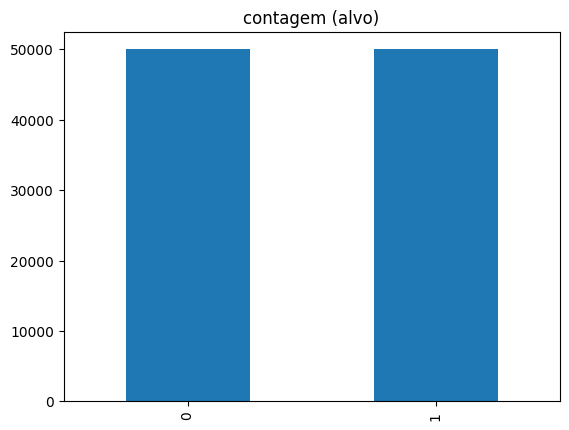

In [93]:
class_count_01, class_count_11 = df_farmix1['target'].value_counts()
class_01 = df_farmix1[df_farmix1['target'] == 0]
class_11 = df_farmix1[df_farmix1['target'] == 1]

class_11_under = class_11.sample(50000)
class_01_under = class_01.sample(50000)

test_under1 = pd.concat([class_01_under, class_11_under], axis=0)

print("total class of 1 e 0 treino:",test_under1['target'].value_counts())
test_under1['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

In [94]:
df_farmix2.target.value_counts()

1    1939269
0     958776
Name: target, dtype: int64

In [95]:
len(class_01_under)

50000

total class of 1 e 0 teste: 0    21428
1    21428
Name: target, dtype: int64


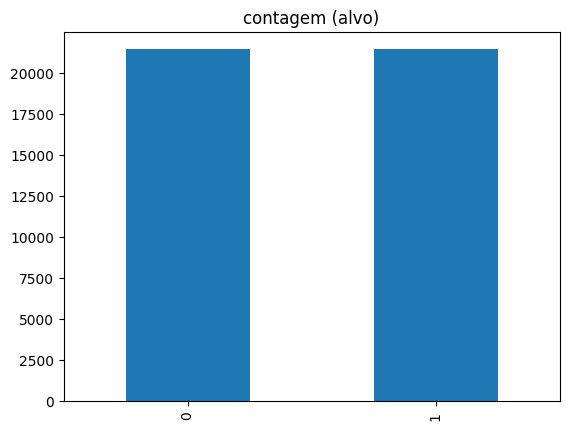

In [96]:
class_count_02, class_count_12 = df_farmix2['target'].value_counts()
class_02 = df_farmix2[df_farmix2['target'] == 0]
class_12 = df_farmix2[df_farmix2['target'] == 1]

#pegar 30% do valor do dataset 1
count30 = int(len(class_01_under)*30/70)
class_12_under = class_12.sample(count30)
class_02_under = class_02.sample(count30)

test_under2 = pd.concat([class_02_under,class_12_under], axis=0)

print("total class of 1 e 0 teste:",test_under2['target'].value_counts())
test_under2['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

### Separando treino e teste

In [97]:
y_train = test_under1['target']
X_train = test_under1[test_under1.columns.difference(['cnpj','target'])]

In [98]:
y_test = test_under2['target']
X_test = test_under2[test_under2.columns.difference(['cnpj','target'])]

In [99]:
X_train = X_train[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe4',
  'classe3',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]
X_test = X_test[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe4',
  'classe3',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]

In [100]:
X_test.head()

,capital_social,classe,classe1,classe2,classe4,classe3,classe5,cnae,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,idade_empresa
1642815,0.0,94928,94928,94928,94928,94928,94928,9492800,9492800,9492800,9492800,9492800,9492800,2395
591386,5000.0,82199,58191,82199,82199,82199,82199,8219999,5819100,8219999,8219999,8219999,8219999,1136
1839849,10000.0,62091,62040,77331,62091,95118,62091,6209100,6204000,7733100,9511800,6209100,6209100,466
794010,0.0,94928,94928,94928,94928,94928,94928,9492800,9492800,9492800,9492800,9492800,9492800,6806
2279718,0.0,94928,94928,94928,94928,94928,94928,9492800,9492800,9492800,9492800,9492800,9492800,1662


In [101]:
X_test.shape

(42856, 14)

In [ ]:
modelo = XGBClassifier(subsample=1.0, min_child_weight=1, max_depth=5, gamma=5, colsample_bytree=1.0)
modelo.fit(X_train, y_train)

In [102]:
# salvando modelo no disco
filename = '/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/finalized_model_farmix.sav'
#pickle.dump(modelo, open(filename, 'wb'))

In [103]:
# lendo modelo do disco
loaded_model = pickle.load(open(filename, 'rb'))

[13:59:46] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [104]:
predict = loaded_model.predict(X_test)
proba = loaded_model.predict_proba(X_test)
result = lambda proba: [round((lista[1] * 100), 2) for lista in proba]
test_under2['probability'] = result(proba)
test_under2['predict'] = predict
test_under2.head()

,cnpj,cnae,capital_social,porte,secao,divisao,grupo,classe,idade_empresa,cnae_sec_1,...,divisao4,grupo4,classe4,secao5,divisao5,grupo5,classe5,target,probability,predict
1642815,25.522.510/0001-50,9492800,0.0,5,19,94,949,94928,2395,9492800,...,94,949,94928,19,94,949,94928,0,3.94,0
591386,36.100.933/0001-06,8219999,5000.0,1,14,82,821,82199,1136,5819100,...,82,821,82199,14,82,821,82199,0,8.69,0
1839849,44.328.395/0001-21,6209100,10000.0,1,10,62,620,62091,466,6204000,...,62,620,62091,10,62,620,62091,0,42.49,0
794010,06.422.912/0001-38,9492800,0.0,5,19,94,949,94928,6806,9492800,...,94,949,94928,19,94,949,94928,0,25.20,0
2279718,31.213.752/0001-64,9492800,0.0,5,19,94,949,94928,1662,9492800,...,94,949,94928,19,94,949,94928,0,4.54,0


#### Comparando os CNAEs de treino e teste

In [18]:
test_under1.shape

(100000, 35)

In [105]:
target1_train = test_under1[test_under1['target'] ==1]

In [106]:
target1_test = test_under2[test_under2['predict'] ==1]

In [ ]:
import plotly.express as px
def plot_histogram(dataframe, x, y, color, width, height):
  fig = px.histogram(dataframe, x=x, y=y, color=color, width=width, 
                     height=height, color_discrete_sequence=['blue', 'red'])
  fig.update_layout(barmode='group', 
                    xaxis={'categoryorder': 'total descending'}, 
                    font=dict(size=12))
  fig.show()

In [ ]:
plot_histogram(test_under2, 'predict', None, 'target', 900, 500)

In [ ]:
print(f"Quantidade de cnaes de treino: {len(target1_train['cnae'].unique())}")
print(f"Quantidade de cnaes de teste: {len(target1_test['cnae'].unique())}")

Quantidade de cnaes de treino: 953
Quantidade de cnaes de teste: 848


In [ ]:
def intersec(list1, list2):
  intersec_cnae = []
  for item in target1_test['cnae'].unique():
      if item in target1_train['cnae'].unique():
          intersec_cnae.append(item)
      else:
          pass
  return intersec_cnae

In [ ]:
print(f"Quantidade de cnaes na interseção: {len(intersec(target1_train['cnae'].unique(),target1_test['cnae'].unique()))}")

Quantidade de cnaes na interseção: 776


####Dados que são realmente do cliente

In [108]:
df = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/df_valid_farmix.csv')
df.head()

,cnpj,capital_social,Classe,Classe1,Classe2,Classe4,Classe3,Classe5,cnae,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,idade_empresa,target
0,35.487.772/0001-84,99800.0,47717,47725,47717,47717,47717,47717,4771701,4772500,NaN,NaN,NaN,NaN,1217,1
1,35.514.016/0001-05,30000.0,47717,47725,47733,47717,47717,47717,4771701,4772500,4773300.0,NaN,NaN,NaN,1215,1
2,35.536.835/0001-45,200000.0,47717,47717,47725,47717,47717,47717,4771701,4771703,4772500.0,NaN,NaN,NaN,1211,1
3,35.709.387/0001-34,99800.0,47717,47211,47296,47610,47296,47725,4771701,4721104,4729602.0,4729699.0,4761002.0,4772500.0,1194,1
4,35.788.676/0001-76,30000.0,47717,47725,47717,47717,47717,47717,4771701,4772500,NaN,NaN,NaN,NaN,1186,1


In [22]:
df_farmix['target'].value_counts()

1    5643
Name: target, dtype: int64

In [23]:
print(f"Quantidade de cnaes diferentes dos clientes reais: {len(df_farmix['cnae'].unique())}")

Quantidade de cnaes diferentes dos clientes reais: 99


In [24]:
intersec_cnae = []
for item in target1_test['cnae'].unique():
    if item in df_farmix['cnae'].unique():
        intersec_cnae.append(item)
    else:
        pass

In [ ]:
intersec_cnae

In [27]:
target1_test['list_cnae'] = [cnae in df_farmix['cnae'].unique() for cnae in target1_test['cnae']]

<ipython-input-27-5977047ccce7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_cnae'] = [cnae in df_farmix['cnae'].unique() for cnae in target1_test['cnae']]


In [31]:
target1_test.shape

(25407, 39)

In [ ]:
target1_test['list_cnae'].value_counts()

False    14880
True     10392
Name: list_cnae, dtype: int64

In [ ]:
target1_test[target1_test['list_cnae'] == True].shape[0]/target1_test.shape[0]

0.41120607787274455

In [29]:
target1_test.head()

,cnpj,cnae,capital_social,porte,secao,divisao,grupo,classe,idade_empresa,cnae_sec_1,...,grupo4,classe4,secao5,divisao5,grupo5,classe5,target,probability,predict,list_cnae
1508098,12.495.366/0001-68,8211300,2000.0,1,14,82,821,82113,4559,6399200,...,821,82113,14,82,821,82113,0,68.09,1,True
2053039,08.105.802/0001-78,8230001,15000.0,1,14,82,823,82300,6097,8230002,...,823,82300,14,82,823,82300,0,65.29,1,False
1604666,20.390.716/0001-50,5611203,72400.0,1,9,56,561,56112,3203,5611201,...,471,47121,7,47,472,47211,0,85.78,1,True
597819,36.785.648/0001-68,1412602,1000.0,1,3,14,141,14126,1071,1529700,...,561,56121,3,15,152,15211,0,82.62,1,False
275271,07.696.220/0001-40,9329804,10000.0,1,18,93,932,93298,6318,5611203,...,932,93298,18,93,932,93298,0,56.18,1,False


In [26]:
df_farmix['grupo'] = [int(str(x)[:3]) for x in df_farmix['cnae']]

In [30]:
target1_test['list_grupo'] = [grupo in df_farmix['grupo'].unique() for grupo in target1_test['grupo']]

<ipython-input-30-55cad77dadbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_grupo'] = [grupo in df_farmix['grupo'].unique() for grupo in target1_test['grupo']]


In [32]:
target1_test['list_grupo'].value_counts()

True     17129
False     8278
Name: list_grupo, dtype: int64

In [33]:
target1_test[target1_test['list_grupo'] == True].shape[0]/target1_test.shape[0]

0.6741842799228559

In [34]:
target1_test['list_classe'] = [classe in df_farmix['Classe'].unique() for classe in target1_test['classe']]
target1_test['list_classe'].value_counts()

<ipython-input-34-33e0f8609809>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_classe'] = [classe in df_farmix['Classe'].unique() for classe in target1_test['classe']]


True     13021
False    12386
Name: list_classe, dtype: int64

In [35]:
target1_test[target1_test['list_classe'] == True].shape[0]/target1_test.shape[0]

0.5124965560672256

In [117]:
target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]
target1_test['cnaesec5'].value_counts()

<ipython-input-117-b90e6acec991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]


False    15056
True     10274
Name: cnaesec5, dtype: int64

In [118]:
target1_test[target1_test['cnaesec5'] == True].shape[0]/target1_test.shape[0]

0.4056060007895776

## Vetbr

In [2]:
df_vetbr1 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/VetBr/new_dataset_vetbr_1ano11.csv')
df_vetbr2 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/VetBr/new_dataset_vetbr_1ano12.csv')

total class of 1 e 0 treino: 0    50000
1    50000
Name: target, dtype: int64


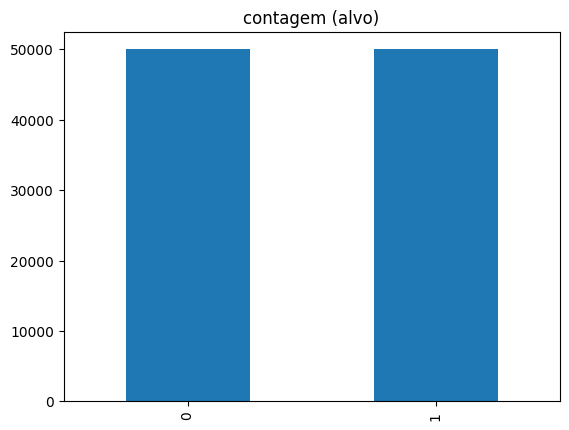

In [3]:
class_count_01, class_count_11 = df_vetbr1['target'].value_counts()
class_01 = df_vetbr1[df_vetbr1['target'] == 0]
class_11 = df_vetbr1[df_vetbr1['target'] == 1]

class_11_under = class_11.sample(50000)
class_01_under = class_01.sample(50000)

test_under1 = pd.concat([class_01_under, class_11_under], axis=0)

print("total class of 1 e 0 treino:",test_under1['target'].value_counts())
test_under1['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

total class of 1 e 0 teste: 0    21428
1    21428
Name: target, dtype: int64


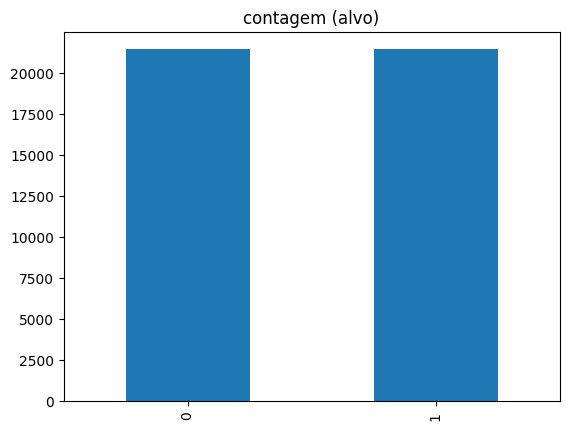

In [4]:
class_count_02, class_count_12 = df_vetbr2['target'].value_counts()
class_02 = df_vetbr2[df_vetbr2['target'] == 0]
class_12 = df_vetbr2[df_vetbr2['target'] == 1]

#pegar 30% do valor do dataset 1
count30 = int(len(class_01_under)*30/70)
class_12_under = class_12.sample(count30)
class_02_under = class_02.sample(count30)

test_under2 = pd.concat([class_02_under,class_12_under], axis=0)

print("total class of 1 e 0 teste:",test_under2['target'].value_counts())
test_under2['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

In [5]:
y_train = test_under1['target']
X_train = test_under1[test_under1.columns.difference(['cnpj','target'])]

In [6]:
y_test = test_under2['target']
X_test = test_under2[test_under2.columns.difference(['cnpj','target'])]

In [7]:
X_train = X_train[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe3',
  'classe4',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]
X_test = X_test[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe3',
  'classe4',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]

#### Modelo

In [ ]:
modelo = XGBClassifier(subsample=1.0, min_child_weight=1, max_depth=5, gamma=5, colsample_bytree=1.0)
modelo.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [8]:
# salvando modelo no disco
filename = '/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/VetBr/finalized_model_etbr.sav'
#pickle.dump(modelo, open(filename, 'wb'))

In [9]:
# lendo modelo do disco
loaded_model = pickle.load(open(filename, 'rb'))

[14:12:49] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [10]:
predict = loaded_model.predict(X_test)
proba = loaded_model.predict_proba(X_test)
result = lambda proba: [round((lista[1] * 100), 2) for lista in proba]
test_under2['probability'] = result(proba)
test_under2['predict'] = predict
test_under2.head()

,cnpj,cnae,capital_social,porte,secao,divisao,grupo,classe,idade_empresa,cnae_sec_1,...,divisao4,grupo4,classe4,secao5,divisao5,grupo5,classe5,target,probability,predict
75394,42.156.939/0001-90,5811500,500.0,1,10,58,581,58115,637,5819100,...,47,476,47610,14,82,823,82300,0,44.78,0
83198,33.618.540/0001-92,5320202,1.0,1,8,53,532,53202,1385,5620104,...,53,532,53202,8,53,532,53202,0,53.87,1
2440497,46.870.775/0001-19,4781400,50000.0,3,7,47,478,47814,250,1412601,...,47,478,47814,7,47,478,47814,0,47.21,0
2836495,27.896.751/0001-94,4722902,4000.0,1,7,47,472,47229,2093,4722902,...,47,472,47229,7,47,472,47229,0,61.81,1
2233995,26.328.193/0001-06,9602502,1000.0,1,19,96,960,96025,2331,9602502,...,96,960,96025,19,96,960,96025,0,42.62,0


#### Comparando os CNAEs de treino e teste

In [45]:
test_under1.shape

(100000, 35)

In [11]:
target1_train = test_under1[test_under1['target'] ==1]

In [12]:
target1_test = test_under2[test_under2['predict'] ==1]

In [ ]:
import plotly.express as px
def plot_histogram(dataframe, x, y, color, width, height):
  fig = px.histogram(dataframe, x=x, y=y, color=color, width=width, 
                     height=height, color_discrete_sequence=['blue', 'red'])
  fig.update_layout(barmode='group', 
                    xaxis={'categoryorder': 'total descending'}, 
                    font=dict(size=12))
  fig.show()

In [ ]:
plot_histogram(test_under2, 'predict', None, 'target', 900, 500)

In [ ]:
print(f"Quantidade de cnaes de treino: {len(target1_train['cnae'].unique())}")
print(f"Quantidade de cnaes de teste: {len(target1_test['cnae'].unique())}")

Quantidade de cnaes de treino: 933
Quantidade de cnaes de teste: 793


In [ ]:
def intersec(list1, list2):
  intersec_cnae = []
  for item in target1_test['cnae'].unique():
      if item in target1_train['cnae'].unique():
          intersec_cnae.append(item)
      else:
          pass
  return intersec_cnae

In [ ]:
print(f"Quantidade de cnaes na interseção: {len(intersec(target1_train['cnae'].unique(),target1_test['cnae'].unique()))}")

Quantidade de cnaes na interseção: 751


####Dados que são realmente do cliente

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/VetBr/df_valid_vetbr.csv')
df.head()

,capital_social,Classe,Classe1,Classe2,Classe4,Classe3,Classe5,cnae,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,idade_empresa,target
0,5000.0,75001,47717,47890,96092,85996,96092,7500100,4771704,4789004.0,8599604.0,9609207.0,9609208.0,1952,1
1,10000.0,47890,47423,47440,47725,47733,96092,4789004,4742300,4744003.0,4773300.0,4772500.0,9609208.0,1196,1
2,5000.0,96092,47890,96092,96092,96092,96092,9609208,4789004,NaN,NaN,NaN,NaN,1155,1
3,50000.0,47890,46231,46923,47717,47440,47890,4789004,4623109,4692300.0,4744001.0,4771704.0,4789002.0,1155,1
4,150000.0,47717,46231,46834,47822,47636,47890,4771704,4623106,4683400.0,4763604.0,4782201.0,4789004.0,1148,1


In [49]:
df['target'].value_counts()

1    3072
Name: target, dtype: int64

In [50]:
print(f"Quantidade de cnaes diferentes dos clientes reais: {len(df['cnae'].unique())}")

Quantidade de cnaes diferentes dos clientes reais: 98


In [51]:
intersec_cnae = []
for item in target1_train['cnae'].unique():
    if item in df['cnae'].unique():
        intersec_cnae.append(item)
    else:
        pass

In [ ]:
len(intersec_cnae)

96

In [ ]:
target1_test['list_cnae'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae']]

<ipython-input-38-4bd27cdb5ecf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_cnae'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae']]


In [ ]:
target1_test.shape

(21666, 38)

In [ ]:
target1_test['list_cnae'].value_counts()

False    13710
True      7956
Name: list_cnae, dtype: int64

In [ ]:
target1_test[target1_test['list_cnae'] == True].shape[0]/target1_test.shape[0]

0.3672112988091941

In [54]:
df['grupo'] = [int(str(x)[:3]) for x in df['cnae']]

In [55]:
target1_test['list_grupo'] = [grupo in df['grupo'].unique() for grupo in target1_test['grupo']]

<ipython-input-55-d02772bb5adf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_grupo'] = [grupo in df['grupo'].unique() for grupo in target1_test['grupo']]


In [56]:
target1_test['list_grupo'].value_counts()

True     16932
False     4710
Name: list_grupo, dtype: int64

In [57]:
target1_test[target1_test['list_grupo'] == True].shape[0]/target1_test.shape[0]

0.7823676185195453

In [58]:
target1_test['list_classe'] = [classe in df['Classe'].unique() for classe in target1_test['classe']]
target1_test['list_classe'].value_counts()

<ipython-input-58-43b73ed8c75d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_classe'] = [classe in df['Classe'].unique() for classe in target1_test['classe']]


True     11502
False    10140
Name: list_classe, dtype: int64

In [59]:
target1_test[target1_test['list_classe'] == True].shape[0]/target1_test.shape[0]

0.531466592736346

In [22]:
target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]
target1_test['cnaesec5'].value_counts()

<ipython-input-22-b90e6acec991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]


False    13872
True      7969
Name: cnaesec5, dtype: int64

In [23]:
target1_test[target1_test['cnaesec5'] == True].shape[0]/target1_test.shape[0]

0.3648642461425759

## Recife Doces

In [60]:
df_recife1 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Recife_Doces/fixed_dataset_recifedoces11.csv')
df_recife2 = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Recife_Doces/fixed_dataset_recifedoces12.csv')

total class of 1 e 0 treino: 0    50000
1    50000
Name: target, dtype: int64


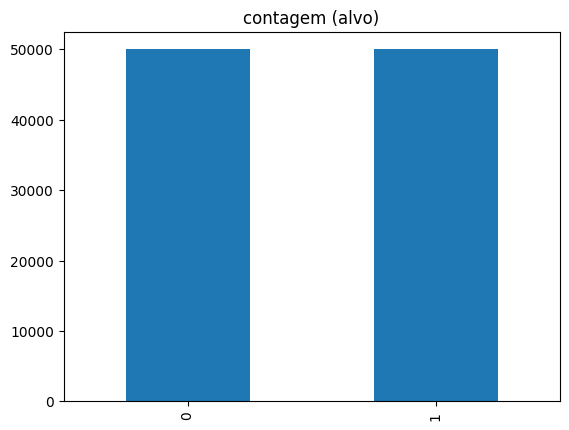

In [61]:
class_count_01, class_count_11 = df_recife1['target'].value_counts()
class_01 = df_recife1[df_recife1['target'] == 0]
class_11 = df_recife1[df_recife1['target'] == 1]

class_11_under = class_11.sample(50000)
class_01_under = class_01.sample(50000)

test_under1 = pd.concat([class_01_under, class_11_under], axis=0)

print("total class of 1 e 0 treino:",test_under1['target'].value_counts())
test_under1['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

total class of 1 e 0 teste: 0    21428
1    21428
Name: target, dtype: int64


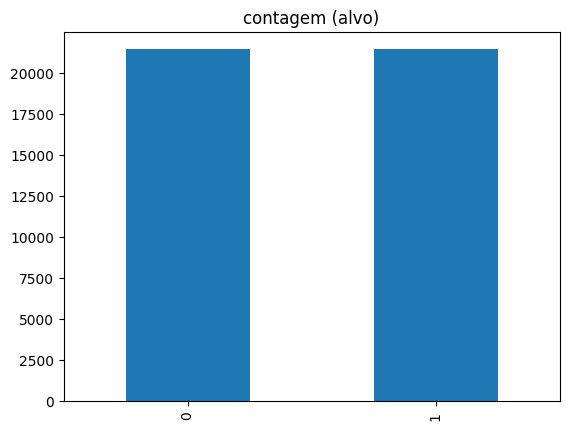

In [62]:
class_count_02, class_count_12 = df_recife1['target'].value_counts()
class_02 = df_recife2[df_recife2['target'] == 0]
class_12 = df_recife2[df_recife2['target'] == 1]

#pegar 30% do valor do dataset 1
count30 = int(len(class_01_under)*30/70)
class_12_under = class_12.sample(count30)
class_02_under = class_02.sample(count30)

test_under2 = pd.concat([class_02_under,class_12_under], axis=0)

print("total class of 1 e 0 teste:",test_under2['target'].value_counts())
test_under2['target'].value_counts().plot(kind='bar', title='contagem (alvo)');

### Separando treino e teste

In [63]:
y_train = test_under1['target']
X_train = test_under1[test_under1.columns.difference(['cnpj','target'])]

In [64]:
y_test = test_under2['target']
X_test = test_under2[test_under2.columns.difference(['cnpj','target'])]

In [65]:
X_train = X_train[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe3',
  'classe4',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]
X_test = X_test[['capital_social',
  'classe',
  'classe1',
  'classe2',
  'classe3',
  'classe4',
  'classe5',
  'cnae',
  'cnae_sec_1',
  'cnae_sec_2',
  'cnae_sec_3',
  'cnae_sec_4',
  'cnae_sec_5',
  'idade_empresa']]

#### Modelo

In [ ]:
modelo = XGBClassifier(subsample=1.0, min_child_weight=1, max_depth=5, gamma=5, colsample_bytree=1.0)
modelo.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [66]:
# salvando modelo no disco
filename = '/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Recife_Doces/finalized_model_recife.sav'
#pickle.dump(modelo, open(filename, 'wb'))

In [67]:
# lendo modelo do disco
loaded_model = pickle.load(open(filename, 'rb'))

In [68]:
predict = loaded_model.predict(X_test)
proba = loaded_model.predict_proba(X_test)
result = lambda proba: [round((lista[1] * 100), 2) for lista in proba]
test_under2['probability'] = result(proba)
test_under2['predict'] = predict
test_under2.head()

,cnpj,cnae,capital_social,porte,secao,divisao,grupo,classe,idade_empresa,cnae_sec_1,...,divisao4,grupo4,classe4,secao5,divisao5,grupo5,classe5,target,probability,predict
17678,39.005.177/0001-16,9492800,0.0,5,19,94,949,94928,885,9492800,...,94,949,94928,19,94,949,94928,0,2.47,0
550268,03.298.363/0001-43,9430800,0.0,5,19,94,943,94308,8674,9493600,...,94,943,94308,19,94,943,94308,0,15.64,0
19161,39.520.962/0001-07,9329804,5000.0,1,18,93,932,93298,859,9329804,...,93,932,93298,18,93,932,93298,0,2.56,0
43976,47.743.285/0001-14,9602501,1200.0,1,19,96,960,96025,184,9602501,...,96,960,96025,19,96,960,96025,0,1.93,0
48261,05.014.142/0001-21,8800600,0.0,5,17,88,880,88006,7616,8800600,...,88,880,88006,17,88,880,88006,0,12.96,0


#### Comparando os CNAEs de treino e teste

In [ ]:
test_under1.shape

(100000, 35)

In [69]:
target1_train = test_under1[test_under1['target'] ==1]

In [70]:
target1_test = test_under2[test_under2['predict'] ==1]

In [ ]:
import plotly.express as px
def plot_histogram(dataframe, x, y, color, width, height):
  fig = px.histogram(dataframe, x=x, y=y, color=color, width=width, 
                     height=height, color_discrete_sequence=['blue', 'red'])
  fig.update_layout(barmode='group', 
                    xaxis={'categoryorder': 'total descending'}, 
                    font=dict(size=12))
  fig.show()

In [ ]:
plot_histogram(test_under2, 'predict', None, 'target', 900, 500)

In [ ]:
print(f"Quantidade de cnaes de treino: {len(target1_train['cnae'].unique())}")
print(f"Quantidade de cnaes de teste: {len(target1_test['cnae'].unique())}")

Quantidade de cnaes de treino: 919
Quantidade de cnaes de teste: 787


In [ ]:
def intersec(list1, list2):
  intersec_cnae = []
  for item in target1_test['cnae'].unique():
      if item in target1_train['cnae'].unique():
          intersec_cnae.append(item)
      else:
          pass
  return intersec_cnae

In [ ]:
print(f"Quantidade de cnaes na interseção: {len(intersec(target1_train['cnae'].unique(),target1_test['cnae'].unique()))}")

Quantidade de cnaes na interseção: 723


####Dados que são realmente do cliente

In [71]:
df = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Recife_Doces/df_valid_recife.csv')
df.head()

,cnpj,capital_social,Classe,Classe1,Classe2,Classe4,Classe3,Classe5,cnae,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,idade_empresa,target
0,35.615.094/0001-98,15000.0,47121,47237,47211,47121,47121,47121,4712100,4723700,4721103.0,NaN,NaN,NaN,1203,1
1,30.501.232/0002-75,95400.0,47237,47296,47237,47237,47237,47237,4723700,4729699,NaN,NaN,NaN,NaN,1203,1
2,36.192.415/0001-51,15000.0,47296,47296,56112,47296,47296,47296,4729602,4729699,5611203.0,NaN,NaN,NaN,1138,1
3,36.464.221/0001-68,5000.0,56112,56201,56112,56112,56112,56112,5611201,5620104,5611203.0,NaN,NaN,NaN,1113,1
4,36.811.257/0001-70,1000.0,47121,95118,43215,47121,47121,47121,4712100,9511800,4321500.0,NaN,NaN,NaN,1078,1


In [ ]:
df['target'].value_counts()

1    2645
Name: target, dtype: int64

In [ ]:
print(f"Quantidade de cnaes diferentes dos clientes reais: {len(df['cnae'].unique())}")

Quantidade de cnaes diferentes dos clientes reais: 173


In [ ]:
intersec_cnae = []
for item in target1_test['cnae'].unique():
    if item in df['cnae'].unique():
        intersec_cnae.append(item)
    else:
        pass

In [ ]:
len(intersec_cnae)

161

In [ ]:
target1_test['list_cnae'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae']]

<ipython-input-55-4bd27cdb5ecf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_cnae'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae']]


In [ ]:
target1_test.shape

(22885, 38)

In [ ]:
target1_test['list_cnae'].value_counts()

True     15831
False     7054
Name: list_cnae, dtype: int64

In [ ]:
target1_test[target1_test['list_cnae'] == True].shape[0]/target1_test.shape[0]

0.6917631636443085

In [72]:
df['grupo'] = [int(str(x)[:3]) for x in df['cnae']]

In [73]:
target1_test['list_grupo'] = [grupo in df['grupo'].unique() for grupo in target1_test['grupo']]

<ipython-input-73-d02772bb5adf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_grupo'] = [grupo in df['grupo'].unique() for grupo in target1_test['grupo']]


In [74]:
target1_test['list_grupo'].value_counts()

True     19354
False     3499
Name: list_grupo, dtype: int64

In [75]:
target1_test[target1_test['list_grupo'] == True].shape[0]/target1_test.shape[0]

0.8468909989935676

In [76]:
target1_test['list_classe'] = [classe in df['Classe'].unique() for classe in target1_test['classe']]
target1_test['list_classe'].value_counts()

<ipython-input-76-43b73ed8c75d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['list_classe'] = [classe in df['Classe'].unique() for classe in target1_test['classe']]


True     18050
False     4803
Name: list_classe, dtype: int64

In [77]:
target1_test[target1_test['list_classe'] == True].shape[0]/target1_test.shape[0]

0.7898306568065462

In [78]:
target1_test.head()

,cnpj,cnae,capital_social,porte,secao,divisao,grupo,classe,idade_empresa,cnae_sec_1,...,classe4,secao5,divisao5,grupo5,classe5,target,probability,predict,list_grupo,list_classe
771445,22.002.460/0001-91,2542000,12000.0,1,3,25,254,25420,2914,2542000,...,25420,3,25,254,25420,0,65.33,1,False,False
621261,18.374.756/0001-66,3314707,10000.0,1,3,33,331,33147,3533,4322302,...,33147,3,33,331,33147,0,90.10,1,True,True
517784,44.835.881/0001-36,2599301,5000.0,1,3,25,259,25993,412,2599301,...,25993,3,25,259,25993,0,64.71,1,True,True
789225,26.857.411/0001-91,5620104,2500.0,1,9,56,562,56201,2238,1096100,...,56201,3,10,109,10911,0,78.47,1,True,True
519414,45.469.237/0001-54,1091102,1000.0,1,3,10,109,10911,366,5620104,...,10911,3,10,109,10911,0,63.18,1,True,True


In [79]:
target1_test['cnaesec1'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_1']]

<ipython-input-79-50c0728824f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['cnaesec1'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_1']]


In [80]:
target1_test['cnaesec1'].value_counts()

True     14910
False     7943
Name: cnaesec1, dtype: int64

In [81]:
target1_test[target1_test['cnaesec1'] == True].shape[0]/target1_test.shape[0]

0.6524307530739947

In [88]:
target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]
target1_test['cnaesec5'].value_counts()

<ipython-input-88-b90e6acec991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target1_test['cnaesec5'] = [cnae in df['cnae'].unique() for cnae in target1_test['cnae_sec_5']]


True     15611
False     7242
Name: cnaesec5, dtype: int64

In [87]:
target1_test[target1_test['cnaesec4'] == True].shape[0]/target1_test.shape[0]

0.6793418807158798